## Парсинг сайта irecommend

In [1]:
from bs4 import BeautifulSoup
import requests
import time
import random

In [2]:
from fake_useragent import UserAgent

In [3]:
ua = UserAgent(verify_ssl=False)
headers = {'User-Agent': ua.random}
print(headers)

{'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'}


In [4]:
session = requests.session()

In [7]:
response = session.get(f'https://irecommend.ru/catalog/reviews/877-897')
response

<Response [200]>

In [8]:
def get_raiting(review):
    div_star = review.find_all('div', class_='star')
    raiting = 0
    for star in div_star: 
        if star.find('div')['class'][0] == 'on':
            raiting += 1
    return raiting 

Собираем ссылки на полный отзыв, пока не наберем каждого типа отзывов по 40 штук. Позитивными я буду считать отзыв с 5 и 4 звездочками, остальные будут негативными. Так как сайт неохотно отдает данные, я подумала, что после 521 ошибки смена user-agent'a и более долгая пауза помогут. Не знаю, правда, помогло это в итоге или нет) 

In [ ]:
reviewlinks = {'positive': [], 'negative': []}
for page in range(40, 100):
    response = session.get(f'https://irecommend.ru/catalog/reviews/877-897?page={page}', headers=headers)
    print(response)
    if response.status_code == 200:
        page_content = BeautifulSoup(response.text)
        review_teasers = page_content.find_all('div', class_='teaser-item')
        for teaser in review_teasers:
            raiting = get_raiting(teaser)
            if raiting < 4:
                label = 'negative'
            else:
                label = 'positive'
            reviewlinks[label].append(teaser.find('div', class_='reviewTextSnippet').find('a', href=True)['href'])
        if (len(reviewlinks['positive']) >= 40) and (len(reviewlinks['negative']) >= 40):
            break
    else:
        time.sleep(random.uniform(30.1, 35.2))
        headers = {'User-Agent': ua.random}
    time.sleep(random.uniform(10.1, 15.2))
reviewlinks

Сохраню ссылки в файл, чтобы больше не перезапускать эту ячейку.

In [9]:
import json

In [ ]:
with open('links.json', 'w') as f:
    json.dump(reviewlinks, f)

In [10]:
with open('links.json', 'r') as f:
    reviewlinks = json.load(f)

In [11]:
len(reviewlinks['negative']), len(reviewlinks['positive'])

(40, 220)

In [12]:
positive = random.choices(reviewlinks['positive'], k=len(reviewlinks['negative'])) 
negative = reviewlinks['negative']

Я сначала брала текст, находящийся внутри тегов \<p>, потому что на нескольких страничках так и было, но потом заметила, что в некоторых отзывах, не хватает части текстов. Посмотрев эти отызвы я поняла, что на этом сайте текст может быть не только внутри тегов \<p> но и где-то просто внутри \<div>. В итоге пришлось брать текст просто с помощью .text из всего div'а, но так туда попадал и текст из ссылок, то пришлось найти все ссылки и удалить их из всего текста...

In [13]:
def get_full_review(review_text):
    soup = BeautifulSoup(review_text)
    review = soup.find('div', class_='reviewText')
    reviewtext = review.text
    
    ahref = review.find_all('a', href=True)
    href_text = [a.text for a in ahref]
    for t in href_text:
        reviewtext = reviewtext.replace(t, '')
        
    reviewtext = reviewtext.replace('\n', '')
    return reviewtext

А еще с этим сайтом какая-то беда, он чуть что выкидывает ошибку 521(( Никакие ожидания и смены user-agent'a не помогают( Поэтому решила сделать рекурсирвную функцию, которая будет запрашивать пока сайт не вернет нормальный ответ 

In [14]:
def get_review(link):
    headers = {'User-Agent': ua.random}
    response = session.get(f'https://irecommend.ru{link}', headers=headers)
    print(link, response)
    if response.status_code == 200:
        return get_full_review(response.text)
    else:
        headers = {'User-Agent': ua.random}
        time.sleep(random.uniform(25.1, 37.2))
        return get_review(link)

In [15]:
positive_reviews = []

In [ ]:
for link in positive:
    positive_reviews.append(get_review(link))
    time.sleep(random.uniform(5.1, 7.2))
positive_reviews

In [17]:
len(positive_reviews)

40

На всякий случай запишу в файл, чтобы больше не парсить сайт, потому что сайт очень плохо отдает данные((((

In [18]:
with open('positive.txt', 'w', encoding='utf-8') as newf:
    newf.write('\n'.join(positive_reviews))

In [19]:
negative_reviews = []

In [25]:
for link in negative:
    negative_reviews.append(get_review(link))
    time.sleep(random.uniform(3.1, 5.2))
negative_reviews

/content/ochen-plokhoi-krem-vykinula-tselyi-tyubik <Response [521]>
/content/ochen-plokhoi-krem-vykinula-tselyi-tyubik <Response [200]>
/content/uzhas-da-i-tolko-istoriya-o-tom-kak-etot-krem-isportil-kozhu <Response [200]>
/content/moe-litso-ne-obradoval <Response [200]>
/content/ne-vsegda-stoit-prislushivatsya-s-predstavitelyam-brenda-v-magazine-i-vot-pochemu <Response [200]>
/content/rezultata-net-ya-ego-zhdala <Response [521]>
/content/rezultata-net-ya-ego-zhdala <Response [200]>
/content/eto-kak-krem-za-4-kosarya-ya-khochu-chtoby-normalno-rabotal-ot-i-do-bez-kakikh-lishnikh-mani <Response [521]>
/content/eto-kak-krem-za-4-kosarya-ya-khochu-chtoby-normalno-rabotal-ot-i-do-bez-kakikh-lishnikh-mani <Response [521]>
/content/eto-kak-krem-za-4-kosarya-ya-khochu-chtoby-normalno-rabotal-ot-i-do-bez-kakikh-lishnikh-mani <Response [200]>
/content/khoroshii-no-zabitye-pory-vse-isportili <Response [200]>
/content/krem-troechnik-no-s-zamashkoi-na-otlichnika-chto-zhe-predstavlyaet-iz-sebya-gial

['Всем солнечного настроения!Одним солнечным тёплым утром...  Попробовала данный крем для лица. А потом и тёплым солнечным вечером тоже. И так несколько дней.  Ароматы... ароматы лаванды... Такие ненавязчивые и приятные.Мои впечатления от использования.Крем и правда питательный. Для меня он оказался на грани того, чтобы быть сколько-нибудь тяжеловатым, хотя ведь не жирный, распределяется хорошо и впитывается также. Ощущение липкости, как иногда бывает у питательных кремов, присутствует, но совсем не критичное, а даже еле-еле заметное. Декоративная косметика, включая праймеры, на данный крем "ложится" без проблем. Понравилась консистенция. Расход вполне себе экономичный. Какого-то эффекта кроме устойчивого увлажнения, мягкости и бархатистости не заметила. Один только этот крем мне ничего не разглаживает, более эластичной кожу не делает Крышечка исправна. Удобно пользоваться.Этим питательным кремом пользовалась как отдельно, так и совместно с другими продуктами от Крымской розы:Так, вся 

In [28]:
len(negative_reviews)

40

In [27]:
with open('negative.txt', 'w', encoding='utf-8') as newf:
    newf.write('\n'.join(negative_reviews))

In [ ]:
with open('positive.txt', 'r', encoding='utf-8-sig')as f:
    positive_reviews = f.readlines()
with open('negative.txt', 'r', encoding='utf-8-sig')as f:
    negative_reviews = f.readlines()

## Токенизация, нормализация

Для начала разобью на тестовую и обучающую выборки:

In [411]:
pos_train, pos_test = positive_reviews[:30], positive_reviews[30:]
neg_train, neg_test = negative_reviews[:30], negative_reviews[30:]

In [412]:
from nltk.tokenize import TweetTokenizer, sent_tokenize
from pymorphy2 import MorphAnalyzer
from string import punctuation
import re

Я решила для токенизации выбрать TweetTokenizer, так как в таких отзывах любят использовать всякие эмодзи и смайлики, а этот токенизатор умеет с ними работать. 

In [413]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
sw = stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kra$0t04ka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [414]:
def normalizer(text):
    text = text.replace('\xa0', ' ')
    text = re.sub(r'[a-zA-Z]+', '', text)
    tknzr = TweetTokenizer()
    morph = MorphAnalyzer()
    tokenized = tknzr.tokenize(text)
    without_sw = [w for w in tokenized if w not in sw]
    clean_text = [w for w in without_sw if w not in punctuation]
    normalized = [morph.parse(w.lower())[0].normal_form for w in clean_text]
    return normalized

In [415]:
from collections import Counter

In [416]:
%%time

positive_words = [w for rev in pos_train for w in normalizer(rev)]
negative_words = [w for rev in neg_train for w in normalizer(rev)]

CPU times: total: 14.9 s
Wall time: 14.9 s


In [417]:
positive_vocab = Counter(positive_words)
negative_vocab = Counter(negative_words)
only_neg = set(negative_vocab.keys()) - set(positive_vocab.keys())
only_pos = set(positive_vocab.keys()) - set(negative_vocab.keys())

In [432]:
only_pos_cnt = Counter({w: c for w, c in positive_vocab.items() if w in only_pos and c > 2})
only_neg_cnt = Counter({w: c for w, c in negative_vocab.items() if w in only_neg and c > 2})

In [419]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

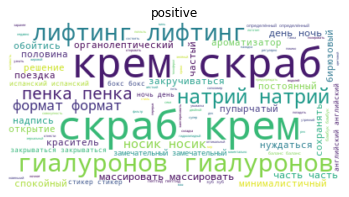

In [433]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(only_pos_cnt.elements()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('positive')
plt.show()

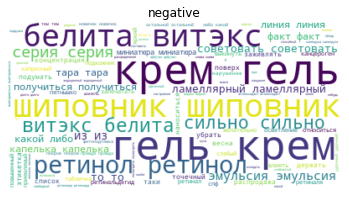

In [434]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(only_neg_cnt.elements()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('negative')
plt.show()

Честно говоря получилась какая-то ерунда( Большая часть слов, какие-то слишком контекстно зависимые и кажется будто вообще не связаны с тональностью... (возможно стоило удалить часть с составом, которая часто встречается в отзывах)

## Предсказания

In [121]:
import numpy as np

Попробую самый примитивный способ: слова из позитивного словаря умножать на их частоту и плюсовать, а из негативного вычитать

In [435]:
only_pos_freq = {w: c / len(positive_vocab) * 100 for w, c in positive_vocab.items() if w in only_pos and c > 1}
only_neg_freq = {w: c / len(negative_vocab) * 100 for w, c in negative_vocab.items() if w in only_neg and c > 1}

In [436]:
def predict(review):
    normalized = normalizer(review)
    rate = 0
    for w in normalized:
        if only_pos_freq.get(w):
            rate += only_pos_freq[w]
        elif only_neg_freq.get(w):
            rate -= only_neg_freq[w]
    return np.sign(rate)

In [437]:
def accuracy(pred, true):
    true = np.array(true)
    pred = np.array(pred)
    if pred.shape == true.shape:
        return (true == pred).sum() / true.shape[0]
    else:
        raise ValueError('Both arrays should have the same shape')

In [438]:
test = []
test.extend([(r, 1) for r in pos_test])
test.extend([(r, -1) for r in neg_test])
random.shuffle(test)
y_test = [r[1] for r in test]
x_test = [r[0] for r in test]

Вообще при таком способе лучше всего работает, если оставить все слова из положительного и отрицательного словаря:

In [439]:
only_pos_freq = {w: c / len(positive_vocab) * 100 for w, c in positive_vocab.items() if w in only_pos and c > 3}
only_neg_freq = {w: c / len(negative_vocab) * 100 for w, c in negative_vocab.items() if w in only_neg and c > 3}
y_pred = [predict(p) for p in x_test]
accuracy(y_pred, y_test)

0.5

In [440]:
only_pos_freq = {w: c / len(positive_vocab) * 100 for w, c in positive_vocab.items() if w in only_pos and c > 1}
only_neg_freq = {w: c / len(negative_vocab) * 100 for w, c in negative_vocab.items() if w in only_neg and c > 1}
y_pred = [predict(p) for p in x_test]
accuracy(y_pred, y_test)

0.6

In [441]:
only_pos_freq = {w: c / len(positive_vocab) * 100 for w, c in positive_vocab.items() if w in only_pos and c > 0}
only_neg_freq = {w: c / len(negative_vocab) * 100 for w, c in negative_vocab.items() if w in only_neg and c > 0}
y_pred = [predict(p) for p in x_test]
accuracy(y_pred, y_test)

0.7

## Возможные улучшения

Что можно сделать: 
- добавить n-граммы (возможно сочетания не с какими-то глаголами/прилагательными будут лучше отражать тональность)
- оставить в ключевых словах только прилагательные и глаголы
- обучить на tf-idf и использовать классификатор
- как-то из отзыва убрать описательную часть, чтобы осталась только часть с мнением о продукте 
- побольше экстраполировать данные, обучаить положительные на отзывах с оценках 5, а отрицательные на 2-3
- нормально почистить данные

### Оставим в словаре только глаголы и прилагательные 

In [442]:
pos = ['ADJF', 'ADJS', 'COMP', 'VERB', 'INFN', 'ADVB']
def normalizer(text):
    text = text.replace('\xa0', ' ')
    text = re.sub(r'[a-zA-Z]+', '', text)
    tknzr = TweetTokenizer()
    morph = MorphAnalyzer()
    tokenized = tknzr.tokenize(text)
    without_sw = [w for w in tokenized if w not in sw]
    clean_text = [w for w in without_sw if w not in punctuation]
    normalized = [morph.parse(w.lower())[0].normal_form for w in clean_text if morph.parse(w.lower())[0].tag.POS in pos]
    return normalized

In [443]:
positive_words = [w for rev in pos_train for w in normalizer(rev)]
negative_words = [w for rev in neg_train for w in normalizer(rev)]
positive_vocab = Counter(positive_words)
negative_vocab = Counter(negative_words)
only_neg = set(negative_vocab.keys()) - set(positive_vocab.keys())
only_pos = set(positive_vocab.keys()) - set(negative_vocab.keys())

In [444]:
only_pos_cnt = Counter({w: c for w, c in positive_vocab.items() if w in only_pos})
only_neg_cnt = Counter({w: c for w, c in negative_vocab.items() if w in only_neg})

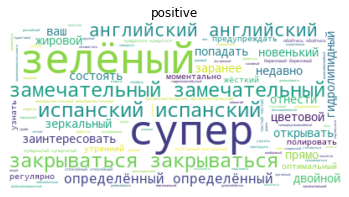

In [445]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(only_pos_cnt.elements()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('positive')
plt.show()

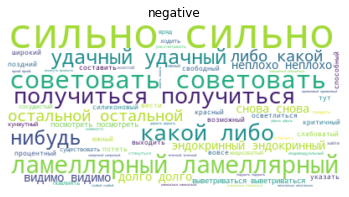

In [446]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(only_neg_cnt.elements()))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('negative')
plt.show()

In [447]:
only_pos_freq = {w: c / len(positive_vocab) * 100 for w, c in positive_vocab.items() if w in only_pos and c > 0}
only_neg_freq = {w: c / len(negative_vocab) * 100 for w, c in negative_vocab.items() if w in only_neg and c > 0}
y_pred = [predict(p) for p in x_test]
accuracy(y_pred, y_test)

0.6

К сожалению стало только хуже( Хотя вордклауды выглядят лучше :)

### Будем использовать n-граммы

In [448]:
from nltk import ngrams

In [449]:
from nltk.tokenize import sent_tokenize

In [450]:
def normalize_sentences(sent_list):
    normalized_sentences = []
    morph = MorphAnalyzer()
    for sent in sent_list:
        normalized_sentences.append([morph.parse(w.lower())[0].normal_form for w in sent])
    return normalized_sentences

In [451]:
def get_bigrams(review):
    review = review.replace('\xa0', ' ')
    review = re.sub(r'[a-zA-Z]+', '', review)
    review = re.sub(r'[!"#$%&\'()*+,-.\/:;<=>?@[\\\]\^_`{\|}~]+', '', review)
    tknzr = TweetTokenizer()
    tokenized = tknzr.tokenize_sents(sent_tokenize(review))
    normalized = normalize_sentences(tokenized)
    bigrams = [el for s in normalized for el in ngrams(s, 2)]
    return bigrams

In [452]:
positive_bigrams = [w for rev in pos_train for w in get_bigrams(rev)]
negative_bigrams = [w for rev in neg_train for w in get_bigrams(rev)]

In [453]:
positive_bigram_vocab = Counter(positive_bigrams)
negative_bigram_vocab = Counter(negative_bigrams)
only_neg_bigram = set(negative_bigram_vocab.keys()) - set(positive_bigram_vocab.keys())
only_pos_bigram = set(positive_bigram_vocab.keys()) - set(negative_bigram_vocab.keys())

In [454]:
only_pos_freq = {w: c / len(positive_bigram_vocab) * 100 for w, c in positive_bigram_vocab.items() if w in only_pos_bigram}
only_neg_freq = {w: c / len(negative_bigram_vocab) * 100 for w, c in negative_bigram_vocab.items() if w in only_neg_bigram}

In [455]:
def predict(review):
    bigrams = get_bigrams(review)
    rate = 0
    for b in bigrams:
        if only_pos_freq.get(b):
            rate += only_pos_freq[b]
        elif only_neg_freq.get(b):
            rate -= only_neg_freq[b]
    return np.sign(rate)

In [456]:
y_pred = [predict(p) for p in x_test]
accuracy(y_pred, y_test)

0.6

К сожалению тоже не помогло( Вообще возможно нужно получше почистить данные, потому что там много склеенных слов и, наверное, это сильно портит биграммы...

### tf-idf

Преобразуем все в датафрейм

In [457]:
import pandas as pd

In [458]:
data = pd.DataFrame({'review': positive_reviews, 'label': np.ones((len(positive_reviews),))})
data = data.append(pd.DataFrame({'review': negative_reviews, 'label': np.ones((len(negative_reviews),)) * -1}))
data['processed'] = data['review']

C:\Users\Kra$0t04ka\AppData\Local\Temp\ipykernel_6580\3822802788.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame({'review': negative_reviews, 'label': np.ones((len(negative_reviews),)) * -1}))


In [459]:
def all_preprocessing(review_text):
    review_text = review_text.replace('\xa0', ' ')
    review_text = re.sub(r'[a-zA-Z]+', '', review_text)
    tknzr = TweetTokenizer()
    tokenized = tknzr.tokenize(review_text)
    without_punc = [t for t in tokenized if t not in punctuation]
    morph = MorphAnalyzer()
    normalized = [morph.parse(t.lower())[0].normal_form for t in without_punc]
    return ' '.join(normalized) 

In [460]:
data['processed'] = data['processed'].apply(all_preprocessing)

In [461]:
data

,review,label,processed
0,Всем привет!Сегодня хочу рассказать о необычно...,1.0,весь привет сегодня хотеть рассказать о необыч...
1,Всем доброго💚Сегодняшний отзыв станет заключит...,1.0,весь добрый 💚 сегодняшний отзыв стать заключит...
2,Всем привет! Сегодня отзыв на дневной крем дл...,1.0,весь привет сегодня отзыв на дневный крем для ...
3,"Когда до 30 осталось всего не чего, пришло сам...",1.0,когда до 30 остаться весь не что прийти самый ...
4,Прошлым летом мне подарили тестовый набор кре...,1.0,прошлое лето я подарить тестовый набор крем с ...
...,...,...,...
35,Впервые слышу про такой бренд. Рекламу не вид...,-1.0,впервые слышать про такой бренд реклама не вид...
36,Всем здравствуйте!Данный продукт для лица от К...,-1.0,весь здравствуйте данный продукт для лицо от к...
37,Всем привет. Об этом креме я наслышана от мног...,-1.0,весь привет о это крем я наслышан от многий зн...
38,"Привет всем красоткам, забежавшим на огонек) С...",-1.0,привет весь красотка забежать на огонёк сегодн...


In [462]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [463]:
tfidf = TfidfVectorizer(
    analyzer="word", 
    stop_words=sw, 
    ngram_range = (1, 2),
)

In [464]:
tfidf.fit(data['processed'])

TfidfVectorizer(ngram_range=(1, 2),
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...])

In [465]:
train = data[:30].append(data[40:70])
test = data[30:40].append(data[70:])

C:\Users\Kra$0t04ka\AppData\Local\Temp\ipykernel_6580\2305569404.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = data[:30].append(data[40:70])
C:\Users\Kra$0t04ka\AppData\Local\Temp\ipykernel_6580\2305569404.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test = data[30:40].append(data[70:])


In [466]:
train_features = tfidf.transform(train['processed'])
train_features.shape

(60, 22939)

In [467]:
test_features = tfidf.transform(test['processed'])
test_features.shape

(20, 22939)

In [468]:
from sklearn.linear_model import LogisticRegression

In [469]:
clf = LogisticRegression(random_state=0)

In [470]:
clf.fit(train_features, train['label'])

LogisticRegression(random_state=0)

In [471]:
y_pred = clf.predict(test_features)

In [472]:
accuracy(y_pred, test['label'])

0.55

Тоже не помогло(